# Random Forest Model and Feature Importance

In this notebook, we will be fitting a **Random Forest Model** on our sampled clean dataset (with all features). We will begin by fitting on our imbalanced clean dataset to have a baseline AUC score. Then we will fit to our downsampled data.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance


#Some of these packages will generate a ton of warnings...
import warnings
warnings.filterwarnings("ignore")

We begin by reading in the pickled train and validation sets from the previous notebook: 

In [10]:
# Imbalanced Clean Data 
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle("y_train.pkl")

X_validation = pd.read_pickle("X_validation.pkl")
y_validation = pd.read_pickle("y_validation.pkl")

As well as the pickled downsampled train and validation sets:

In [7]:
# Downsampled Data (20% sampling rate)
%store -r X_train_down_bal_20
%store -r y_train_down_bal_20

---

### Base Random Forest Model -- No Sampling

First let's fit our base model on the imbalanced data. We will continue to use AUC as our scoring metric. 

We will search for the optimal hyperparameters for our base Random Forest model using a grid search. Let's keep the max_depth low to just 2 decisions for a given tree, and have a maximum of 41 estimators (trees) to minimize the iterations of the cv folds.

In [12]:
# instantiate the model
my_rf = RandomForestClassifier()

# set the parameters for the grid
param_grid = {'n_estimators': np.arange(1, 50, 10), 
              'max_depth': np.arange(1, 3),
             }

base_rf = GridSearchCV(my_rf, param_grid = param_grid, scoring='roc_auc', cv=3, verbose = 2)

base_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.7s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.4s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.4s
[CV] END .......................max_depth=1, n_estimators=11; total time=   1.3s
[CV] END .......................max_depth=1, n_estimators=11; total time=   1.2s
[CV] END .......................max_depth=1, n_estimators=11; total time=   1.0s
[CV] END .......................max_depth=1, n_estimators=21; total time=   1.8s
[CV] END .......................max_depth=1, n_estimators=21; total time=   1.8s
[CV] END .......................max_depth=1, n_estimators=21; total time=   2.1s
[CV] END .......................max_depth=1, n_estimators=31; total time=   2.6s
[CV] END .......................max_depth=1, n_estimators=31; total time=   2.6s
[CV] END .......................max_depth=1, n_e

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2]),
                         'n_estimators': array([ 1, 11, 21, 31, 41])},
             scoring='roc_auc', verbose=2)

In [20]:
base_rf.best_estimator_

RandomForestClassifier(max_depth=2, n_estimators=41)

The grid search has optimized the number of estimators to be 41. Let's investigate the minimum number of estimators required to still obtain optimal model performance on the validation.

In [13]:
# AUC score on train sets
base_rf.score(X_train, y_train)

0.9630114719920165

In [14]:
# AUC score on validation sets
base_rf.score(X_validation, y_validation)

0.9614613271988397

In [15]:
# AUC scores for each fold
base_rf.cv_results_["mean_test_score"]

array([0.70865601, 0.94441292, 0.95302651, 0.94818728, 0.95187676,
       0.80125367, 0.94960043, 0.95882975, 0.95910127, 0.96561994])

With 41 estimators and max depth 2, the base Random Forest model has a best AUC score on the validation of 96% across all 3 cv folds. 

In [16]:
# we cast max_depth to str so that seaborn treats it like a category,
# which is better for visuals
base_rf_results = pd.DataFrame({
    "n_estimators": base_rf.cv_results_["param_n_estimators"],
    'max_depth': base_rf.cv_results_["param_max_depth"].astype(str),
    'mean_score': base_rf.cv_results_["mean_test_score"]
})

base_rf_results.head()

,n_estimators,max_depth,mean_score
0,1,1,0.708656
1,11,1,0.944413
2,21,1,0.953027
3,31,1,0.948187
4,41,1,0.951877


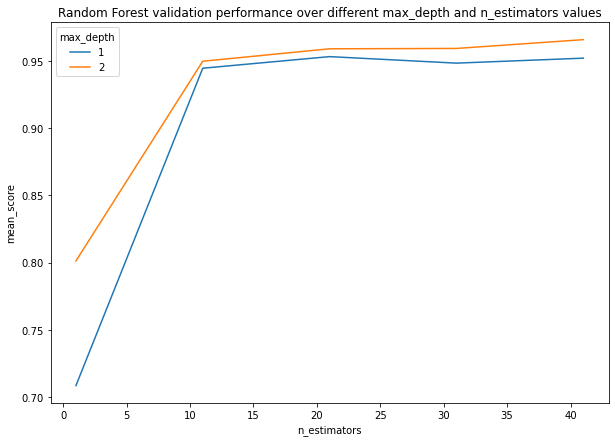

In [19]:
plt.figure(figsize=(10, 7))
sns.lineplot(x="n_estimators", y="mean_score", hue="max_depth", data=base_rf_results)
plt.title("Random Forest validation performance over different max_depth and n_estimators values")
plt.show()


From this visualization we can see that the optimal model performance ocurs when 10 < `n_estimators` < 41 . So, the minimum number of estimators that we can fit our base model without sacrificing loss in model performance is with `n_estimators` = 10.

Let's try a bigger range for `max_depth` to see if we get a better result.

In [24]:
# instantiate the model
my_rf = RandomForestClassifier()

# set the parameters for the grid
param_grid = {'n_estimators': [10], # keeping min n_estimator 
              'max_depth': np.arange(1, 10),
             }

base_rf_ = GridSearchCV(my_rf, param_grid = param_grid, scoring='roc_auc', cv=3, verbose = 2)

base_rf_.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................max_depth=1, n_estimators=10; total time=   1.2s
[CV] END .......................max_depth=1, n_estimators=10; total time=   1.0s
[CV] END .......................max_depth=1, n_estimators=10; total time=   1.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   1.4s
[CV] END .......................max_depth=2, n_estimators=10; total time=   1.4s
[CV] END .......................max_depth=2, n_estimators=10; total time=   1.4s
[CV] END .......................max_depth=3, n_estimators=10; total time=   2.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   2.0s
[CV] END .......................max_depth=3, n_estimators=10; total time=   1.7s
[CV] END .......................max_depth=4, n_estimators=10; total time=   2.2s
[CV] END .......................max_depth=4, n_estimators=10; total time=   2.3s
[CV] END .......................max_depth=4, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': [10]},
             scoring='roc_auc', verbose=2)

In [25]:
base_rf_.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=10)

In [104]:
# AUC score on validation sets
base_rf_.score(X_validation, y_validation)

0.9888451250059456

By increasing the max depth to 9 and decreasing the number of estimators to 10 the model performance has improved having a best AUC score on the validation across all 3 cv folds of 98.88%.

In [34]:
base_rf_results2 = pd.DataFrame({
    "n_estimators": base_rf_.cv_results_["param_n_estimators"],
    'max_depth': base_rf_.cv_results_["param_max_depth"].astype(str),
    'mean_score': base_rf_.cv_results_["mean_test_score"]
})

base_rf_results2.head()

,n_estimators,max_depth,mean_score
0,10,1,0.940003
1,10,2,0.944148
2,10,3,0.962532
3,10,4,0.969558
4,10,5,0.975105


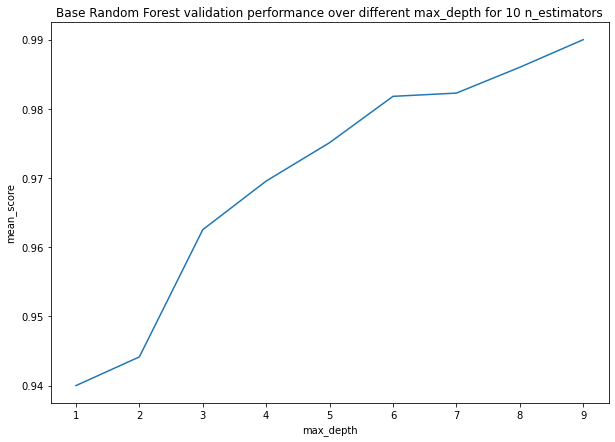

In [38]:
plt.figure(figsize=(10, 7))
sns.lineplot(x="max_depth", y="mean_score", data=base_rf_results2)
plt.title("Base Random Forest validation performance over different max_depth for 10 n_estimators")
plt.show()

We can see that increasing the max_depth from 2 to 9 increases the AUC score on our validation set by about 5%. 

---

### Downsampled Random Forest Model

Now that we have our base model, let's fit to our downsampled dataset (least computationally expensive). We will explore options for the following parameters `n_estimators` and `max_depth`. 

In [26]:
# instantiate the model
my_rf = RandomForestClassifier()

# set the parameters for the grid
param_grid = {'n_estimators': np.arange(1, 40, 10), 
              'max_depth': np.arange(1, 10),
             }

up_rf = GridSearchCV(my_rf, param_grid = param_grid, scoring='roc_auc', cv=3, verbose = 2)

up_rf.fit(X_train_down_bal_20, y_train_down_bal_20)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.3s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=21; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=21; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=21; total time=   0.6s
[CV] END .......................max_depth=1, n_estimators=31; total time=   0.8s
[CV] END .......................max_depth=1, n_estimators=31; total time=   0.8s
[CV] END .......................max_depth=1, n_

[CV] END .......................max_depth=9, n_estimators=11; total time=   1.1s
[CV] END .......................max_depth=9, n_estimators=21; total time=   2.6s
[CV] END .......................max_depth=9, n_estimators=21; total time=   2.6s
[CV] END .......................max_depth=9, n_estimators=21; total time=   2.2s
[CV] END .......................max_depth=9, n_estimators=31; total time=   3.6s
[CV] END .......................max_depth=9, n_estimators=31; total time=   3.7s
[CV] END .......................max_depth=9, n_estimators=31; total time=   3.2s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 1, 11, 21, 31])},
             scoring='roc_auc', verbose=2)

In [27]:
up_rf.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=21)

In [29]:
down_rf_results = pd.DataFrame({
    "n_estimators": up_rf.cv_results_["param_n_estimators"],
    'max_depth': up_rf.cv_results_["param_max_depth"].astype(str),
    'mean_score': up_rf.cv_results_["mean_test_score"]
})

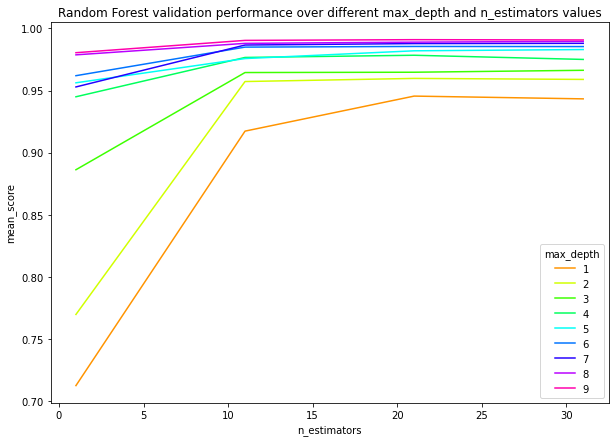

In [88]:
plt.figure(figsize=(10, 7))
sns.lineplot(x="n_estimators", y="mean_score", hue="max_depth", palette="hsv",data=down_rf_results)
plt.title("Random Forest validation performance over different max_depth and n_estimators values")
plt.show()

Although the grid search tells us that 21 estimators is best, we can see that the minimum number of estimators needed to get a high mean AUC validation score is around 10. 

So, let's fit a random forest model with `n_estimators` = 10 and `max_depth`=9.

In [8]:
# Downsampled Random Forest Model with n_estimators = 10 and max_depth = 9
down_rf_model=RandomForestClassifier(n_estimators= 10, max_depth=9, random_state=1)
down_rf_model.fit(X_train_down_bal_20,y_train_down_bal_20)


RandomForestClassifier(max_depth=9, n_estimators=10, random_state=1)

**ROC Curve and AUC Scores**

We get the soft predictions on both the downsampled train and validation set in order to calculate the respective AUC scores: 

In [11]:
y_proba_train_down = down_rf_model.predict_proba(X_train_down_bal_20)[:, 1]
y_proba_val_down = down_rf_model.predict_proba(X_validation)[:, 1]

 # Score (AUC)
auc_train_down = np.round(roc_auc_score(y_train_down_bal_20, y_proba_train_down), 3)
auc_val_down = np.round(roc_auc_score(y_validation, y_proba_val_down), 3)

In [95]:
print(f"The Training AUC score is:  {auc_train_down}")
print(f"The Validation AUC score is:  {auc_val_down}")

The Training AUC score is:  0.992
The Validation AUC score is:  0.99


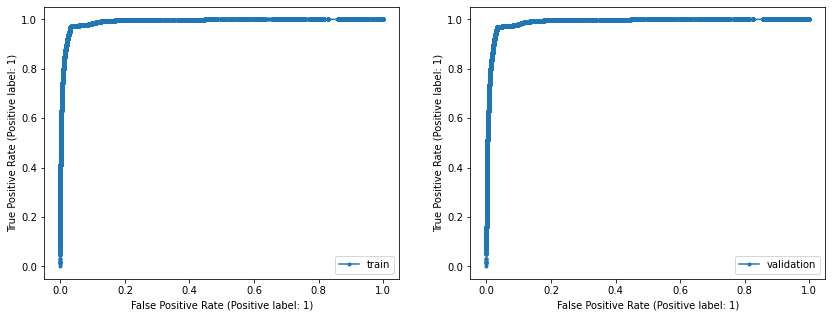

In [96]:
# Plot ROC curve of Downsampled Random Forest Model using plot_roc_curve

fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(down_rf_model, X_train_down_bal_20, y_train_down_bal_20, ax=axes[0], marker='.', label='train')
plot_roc_curve(down_rf_model, X_validation, y_validation, ax=axes[1], marker='.', label='validation')
plt.show()

Confusion matrices: 



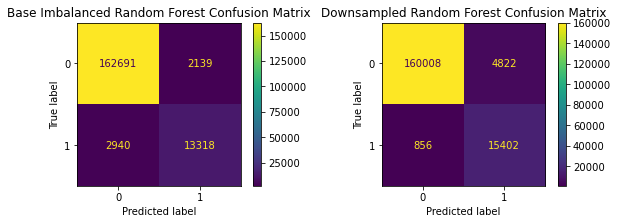


Base Random Forest Model on imbalanced data with max_depth=9 and n_estimators=10 classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    164830
           1       0.86      0.82      0.84     16258

    accuracy                           0.97    181088
   macro avg       0.92      0.90      0.91    181088
weighted avg       0.97      0.97      0.97    181088


 Downsampled Random Forest Model with max_depth=9 and n_estimators=10 classification report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    164830
           1       0.76      0.95      0.84     16258

    accuracy                           0.97    181088
   macro avg       0.88      0.96      0.91    181088
weighted avg       0.97      0.97      0.97    181088



In [103]:
# Confusion matrices
print_line = "\n=======================================================\n"

print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Base Model on the original imbalanced data with max_depth=9 and n_estimators=10
plot_confusion_matrix(base_rf_, X_validation, y_validation, ax=axes[0])
axes[0].set_title('Base Imbalanced Random Forest Confusion Matrix')

# Model on the 20% upsampled data
plot_confusion_matrix(down_rf_model, X_validation, y_validation, ax=axes[1])
axes[1].set_title('Downsampled Random Forest Confusion Matrix')

plt.show()

# base hard predictions
y_pred_base_rf_= base_rf_.predict(X_validation)
report_base_rf_ = classification_report(y_validation, y_pred_base_rf_)

# downsampled hard predictions
y_pred_down_rf= down_rf_model.predict(X_validation)
report_down_rf = classification_report(y_validation, y_pred_down_rf)


print("\nBase Random Forest Model on imbalanced data with max_depth=9 and n_estimators=10 classification report:", print_line, report_base_rf_)
print("\n Downsampled Random Forest Model with max_depth=9 and n_estimators=10 classification report:", print_line, report_down_rf)



In terms of the AUC score on the validation set, both models have a high model performance of 99%. In terms of precision, recall, and f1-score, there is no clear improvement in these metrics on the downsampled model in comparison to the base on the imbalanced data. Recall increased by 13% (from 82% to 95%), f1-score is 84% for both models, and precision went down by 10% (from 86% to 76%). 

---

### Final Test Score

In this section, we will select our final best model out of Logistic and Random Forest and compare our churn prediction to the test set that we have reserved. Both our base and downsampled Random Forest Models have AUC validation scores of 99% and f1-scores of 84% and were fit with the same hyperpararamters having max depth 9 and 10 estimators.

Let's read in our pickled remainder and test sets:

In [17]:
X_remainder= pd.read_pickle('X_remainder.pkl')
y_remainder= pd.read_pickle("y_remainder.pkl")

X_test= pd.read_pickle("X_test.pkl")
y_test = pd.read_pickle('y_test.pkl')

**Best Model Test AUC score and Classification Report**

We re-fit our best Random Forest Model onto our remainder sets and predict on the test sets.

In [18]:
# Best Random Forest Model with n_estimators = 10 and max_depth = 9 fit to remainder
RF_model=RandomForestClassifier(n_estimators= 10, max_depth=9, random_state=1)
RF_model.fit(X_remainder,y_remainder)

RandomForestClassifier(max_depth=9, n_estimators=10, random_state=1)

In [19]:
#soft test prediction
y_proba_test = RF_model.predict_proba(X_test)[:, 1]

 # Test Score (AUC)
auc_test = np.round(roc_auc_score(y_test, y_proba_test), 3)

In [23]:
# hard test prediciton
y_pred_test = RF_model.predict(X_test)
test_report = classification_report(y_test, y_pred_test)
print("\n Random Forest Model with max_depth=9 and n_estimators=10 Test Classification Report:", print_line,test_report)
print("\n AUC Test Score:", auc_test)


 Random Forest Model with max_depth=9 and n_estimators=10 Test Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    137469
           1       0.86      0.81      0.84     13438

    accuracy                           0.97    150907
   macro avg       0.92      0.90      0.91    150907
weighted avg       0.97      0.97      0.97    150907


 AUC Test Score: 0.987


Our final model has successfully predicted churn with a 98.7% AUC score on the test set, and has an f1-score of 84%, recall of 81%, and precision of 86%. 

---

### Feature Importance

In this section, we analyze the importance of the features of our Random Forest Model in predicting churn. 

#### Base Model

In [119]:
base_feature_importances = base_rf_.best_estimator_.feature_importances_

# Put the variable names and their feature importances into a data frame
base_importances_df = pd.DataFrame({'Variable': X_train.columns,
                               'Importance': base_feature_importances})
base_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True) # Sort Feature Importance in descending order

base_importances_df

,Variable,Importance
0,membership_days,0.327262
1,mem_exp_month,0.204501
2,last_log_day,0.127782
3,is_auto_renew,0.072733
4,trans_month,0.047893
5,is_cancel,0.043481
6,notAutorenew_&_cancel,0.027013
7,autorenew_&_not_cancel,0.025896
8,mem_exp_day,0.023296
9,pay_38,0.019451


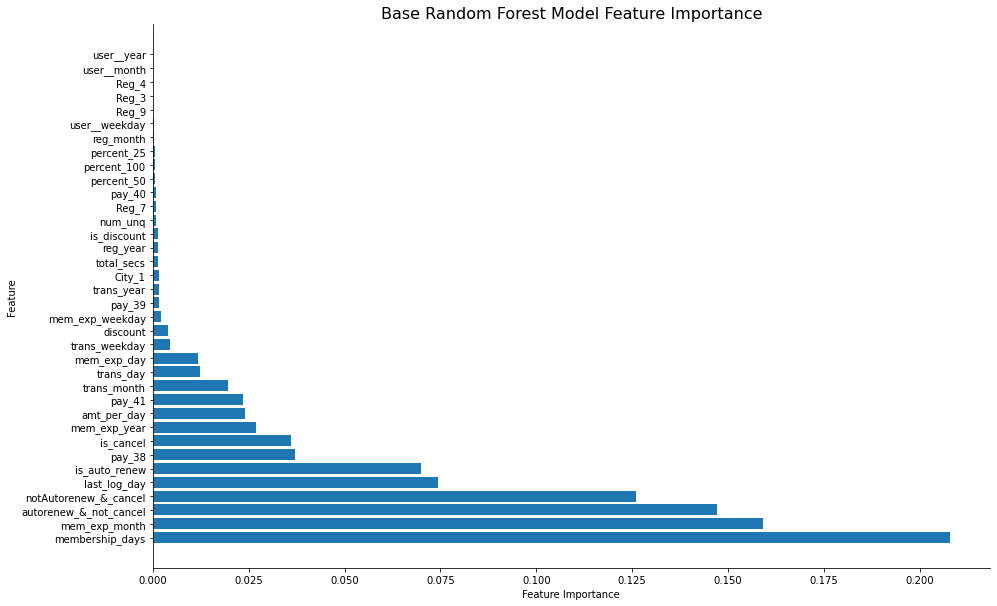

In [120]:
plt.figure(figsize=(15,10))

plt.barh(down_importances_df['Variable'], down_importances_df['Importance'])
plt.title('Base Random Forest Model Feature Importance', fontsize=16)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
sns.despine()
plt.show()

---

#### Downsampled model

In [109]:
down_feature_importances = down_rf_model.feature_importances_

# Put the variable names and their feature importances into a data frame
down_importances_df = pd.DataFrame({'Variable': X_train.columns,
                               'Importance': down_feature_importances})
down_importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True) # Sort Feature Importance in descending order


down_importances_df

,Variable,Importance
0,membership_days,0.207877
1,mem_exp_month,0.159035
2,autorenew_&_not_cancel,0.147203
3,notAutorenew_&_cancel,0.126064
4,last_log_day,0.074272
5,is_auto_renew,0.069868
6,pay_38,0.036960
7,is_cancel,0.035925
8,mem_exp_year,0.026793
9,amt_per_day,0.024034


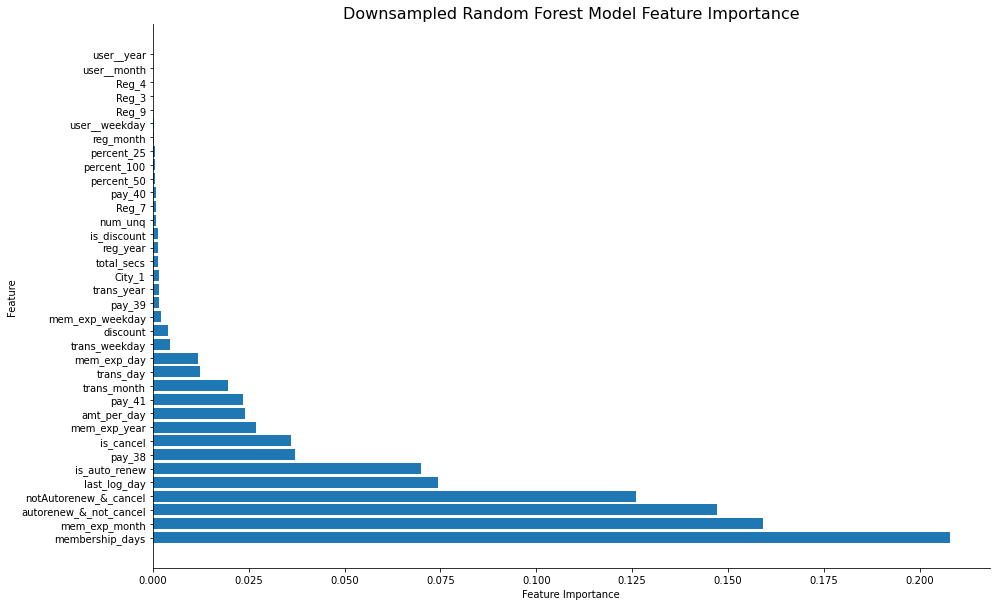

In [115]:
plt.figure(figsize=(15,10))

plt.barh(down_importances_df['Variable'], down_importances_df['Importance'])
plt.title('Downsampled Random Forest Model Feature Importance', fontsize=16)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
sns.despine()
plt.show()

---

## Recommendations

The most important features that drive churn prediction are: 

- membership duration
- membership expiration month
- autorenewing and not cancelling an existing membership
- not autorenewing and cancelling an existing membership
- the last day a member used KKbox music app
- autorenewing an existing membership
- payment method 38
- membership subscription cancellation


This is consistent with our findings of our Logistic Regression Model in the previous notebook. We see again that membership duration has the biggest impact on churn prediction. What is different for our Random Forest Model in comparison to the Logistic Model is that the combinations of autorenewing and not cancelling an existing membership as well as not autorenewing and cancelling an existing membership are top important predictors of churn. We lost this importance in our Logistic Model most likely because they introduced multicollinearity. As we expected, these specific combinations give more information and lead to a better forecasting of churn. It is also interesting to note that the original features autorenewal and cancellation do not drive the prediction as much as their combinations do and offer less insight. It appears that our Random Forest Model picked up on the importance of payment method 38. We can infer that this payment method might not be a credit card so KKBox should consider promoting payment methods that lead to setting up autopay and autorenewal.  

---

### Churn Rate Prediction

In this final section, we will use the final test churn prediction from our best Random Forest Model to calculate the churn rate prediction as a percentage. In combination with the revenue we can determine the expected revenue loss from losing customers. We know the revenue from our EDA notebook as it is the actual amount paid for a plan. We will consider paid plan amounts of $150 in our calculation as we know that this is the most frequent plan used. 

First, we find the number of members that our model predicted to churn:

In [34]:
churn_members = np.sum(y_pred_test==1)
churn_members

12690

Now, we calculate the predicted churn rate by dividing the number of predicted churn members by the total number of members that we had initially in our clean dataset. We know this from our EDA to be 970,960 members. 

In [36]:
churn_rate = (churn_members/970960)*100
churn_rate

1.3069539424899068

Our churn prediction translates into a revenue loss of:

In [38]:
revenue_loss = churn_members*150
revenue_loss

1903500

### Final Concluding Remarks

By predicting the churn rate of 1.3%, KKBox can expect a revenue loss of $2 million if customer retention is not improved. These findings help KKbox gain a better understanding of their future expected revenue. Additionally, KKBox can use these results to identify and improve upon areas where customer service is lacking. Their marketing team can understand what preventative steps are necessary to ensure lost revenue is minimized. Particularly, they can focus on the most important features from our Random Forest Modelling results to make improvements in customer lifetime value as well as retention and further reduce the churn rate and revenue loss. 